<a href="https://colab.research.google.com/github/SRPOOJA99/AI-Assistant---Data-Analyst/blob/main/The_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the notebook

### Task 1 - Set up the project environment

In [1]:
!pip install --upgrade openai==1.7.2 python-dotenv httpx==0.23.0

Importing modules

In [2]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
from io import BytesIO

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [3]:
load_dotenv('apikey.env.txt')

APIKEY = os.getenv("APIKEY")

Creating OpenAI Client

In [4]:
client = OpenAI(
 api_key = APIKEY
)
client

### Task 2 - Create the AI Assistant

Now let's load our dataset into a File Object

In [33]:
data_file = client.files.create(
    file = open('product_sales_dataset.json', 'rb'),
    purpose = 'assistants'
)
data_file

FileObject(id='file-GUUzdGgZU5YfUtaSG6U2Pe', bytes=1456230, created_at=1744922702, filename='product_sales_dataset.json', object='file', purpose='assistants', status='processed', status_details=None, expires_at=None)

Let's define our Assistant object.

In [34]:
def create_assistant(file):
  assistant = client.beta.assistants.create(
    name = "Data Analyst",
    description = "You are a Data Analyst. You know to analyse data and extract insights. You will be given a json file containing the data related to sales of the online toy store and will use data analysis and coding skills to provide valuable answers to the user's analytical queries.",
    model = 'gpt-4-1106-preview',
    tools = [{"type":"code_interpreter"}],
    file_ids = [data_file.id],
    extra_headers = {"OpenAI-Beta": "assistants=v2"}
  )
  return assistant

assistant = create_assistant(file)


BadRequestError: Error code: 400 - {'error': {'message': "Unknown parameter: 'file_ids'.", 'type': 'invalid_request_error', 'param': 'file_ids', 'code': 'unknown_parameter'}}

### Task 3 - Communicate with the AI Assistant through Threads

> The **User** can communicate with the AI assistant through a **Thread** object. A thread can contain one or multiple **Message** objects. <br>
> We can then use a **Run** object to send our message to the AI assistant.




Let's define an empty thread. 🧵


In [7]:
thread = client.beta.threads.create(extra_headers={"OpenAI-Beta": "assistants=v2"})
thread

assistant = "asst_QBypIv4Hpa5hKjm6OoG9ucOx"

Now let's create a message and add it to thread.

In [8]:
question = 'Which product has the highest number of sold items?'
message =client.beta.threads.messages.create(
    thread_id = thread.id,
    role = 'user',
    content = question,
    extra_headers={"OpenAI-Beta": "assistants=v2"}
)
message

ThreadMessage(id='msg_AqZ4JW6jxGwdBrfabmYCVqo0', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Which product has the highest number of sold items?'), type='text')], created_at=1744921677, file_ids=None, metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_uYs99PP9QDmgybCiGmO5bKpe', attachments=[])

Creating a `Run` object to send our request to the AI Assistant.

In [9]:
run = client.beta.threads.runs.create(
  thread_id = thread.id,
  assistant_id = assistant,
  extra_headers={"OpenAI-Beta": "assistants=v2"}
)
run


Run(id='run_O5RDZbbDM0T0WfbJkvczT3CB', assistant_id='asst_QBypIv4Hpa5hKjm6OoG9ucOx', cancelled_at=None, completed_at=None, created_at=1744921678, expires_at=1744922278, failed_at=None, file_ids=None, instructions=None, last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=None, status='queued', thread_id='thread_uYs99PP9QDmgybCiGmO5bKpe', tools=[ToolAssistantToolsCode(type='code_interpreter'), ToolAssistantToolsCode(type='file_search', file_search={'ranking_options': {'ranker': 'default_2024_08_21', 'score_threshold': 0.0}})], tool_resources={}, temperature=1.0, top_p=1.0, reasoning_effort=None, max_completion_tokens=None, max_prompt_tokens=None, truncation_strategy={'type': 'auto', 'last_messages': None}, incomplete_details=None, usage=None, response_format={'type': 'text'}, tool_choice='auto', parallel_tool_calls=True)

### Task 4 - Retrieve results from the AI Assistant

Let's retrieve the run object to check the status of the run

In [36]:
response_run = client.beta.threads.runs.retrieve(
    thread_id = thread.id,
    run_id = run.id,
    extra_headers={"OpenAI-Beta": "assistants=v2"}
)
response_run.status

'completed'

Now let's retrieve the messages from the AI Assistant

In [11]:
messages = client.beta.threads.messages.list(
    thread_id = thread.id,
    extra_headers={"OpenAI-Beta": "assistants=v2"}
)
list(messages)

[ThreadMessage(id='msg_AqZ4JW6jxGwdBrfabmYCVqo0', assistant_id=None, content=[MessageContentText(text=Text(annotations=[], value='Which product has the highest number of sold items?'), type='text')], created_at=1744921677, file_ids=None, metadata={}, object='thread.message', role='user', run_id=None, thread_id='thread_uYs99PP9QDmgybCiGmO5bKpe', attachments=[])]

### Task 5 - Create charts with AI Assistant

In [39]:
def send_message(assistant_id, thread_id, message_content):
      """
      Sends a message to an AI assistant,
      waits for the response run to be completed,
      and then retrieves the list of messages in the thread.
      """

      # creating message
      message = client.beta.threads.messages.create(
        thread_id = thread_id,
        role = "user",
        content = message_content,
        extra_headers={"OpenAI-Beta": "assistants=v2"}
      )

      # creating request run
      request_run = client.beta.threads.runs.create(
            thread_id = thread_id,
            assistant_id = assistant_id,
            extra_headers={"OpenAI-Beta": "assistants=v2"}
      )

      # wait until the response_run is completed
      while True:
            # retrieve the run
            response_run = client.beta.threads.runs.retrieve(
                  thread_id = thread_id,
                  run_id = request_run.id,
                  extra_headers={"OpenAI-Beta": "assistants=v2"}
            )

            print("status > "+response_run.status)

            time.sleep(1)

            if(response_run.status=="completed"):
              time.sleep(1)
              break

      messages = client.beta.threads.messages.list(
            thread_id = thread_id,
            extra_headers={"OpenAI-Beta": "assistants=v2"}
      )

      return list(messages)

In [40]:
question = "In which day of the week we have the highest number of sold items?"
messages = send_message(
    assistant,
    thread.id,
    question

    )
print(messages)

status > queued
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > completed
[ThreadMessage(id='msg_7FfFkDUyqULLspMIDBytw5MP', assistant_id='asst_QBypIv4Hpa5hKjm6OoG9ucOx', content=[MessageContentText(text=Text(annotations=[], value='The day of the week with the highest number of sold items is Sunday, with a total of 798 items sold.'), type='text')], created_at=1744923302, file_ids=None, metadata={}, object='thread.message', role='assistant', run_id='run_gGtyYEJ0tEurVpaEo2NeNRFJ', thread_id='thread_uYs99PP9QDmgybCiGmO5bKpe', attachments=[]), ThreadMessage(id='msg_MN62dDUXkmFq5LGEbyfWTkYT', assistant_id=None, content=[MessageContentText

Let's ask the assistant to create a histogram of the product price column.

In [53]:
question = "create a histogram of product price column"
messages= send_message(assistant,thread.id,question)


answer = messages[0]


status > queued
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > completed


Let's take a look at the answer and extract the image file

In [54]:
file_id = answer.content[0].image_file.file_id
print(file_id)

file-JfbhNmpD41Yf4hhZGKXvfQ


Let's retrieve the file

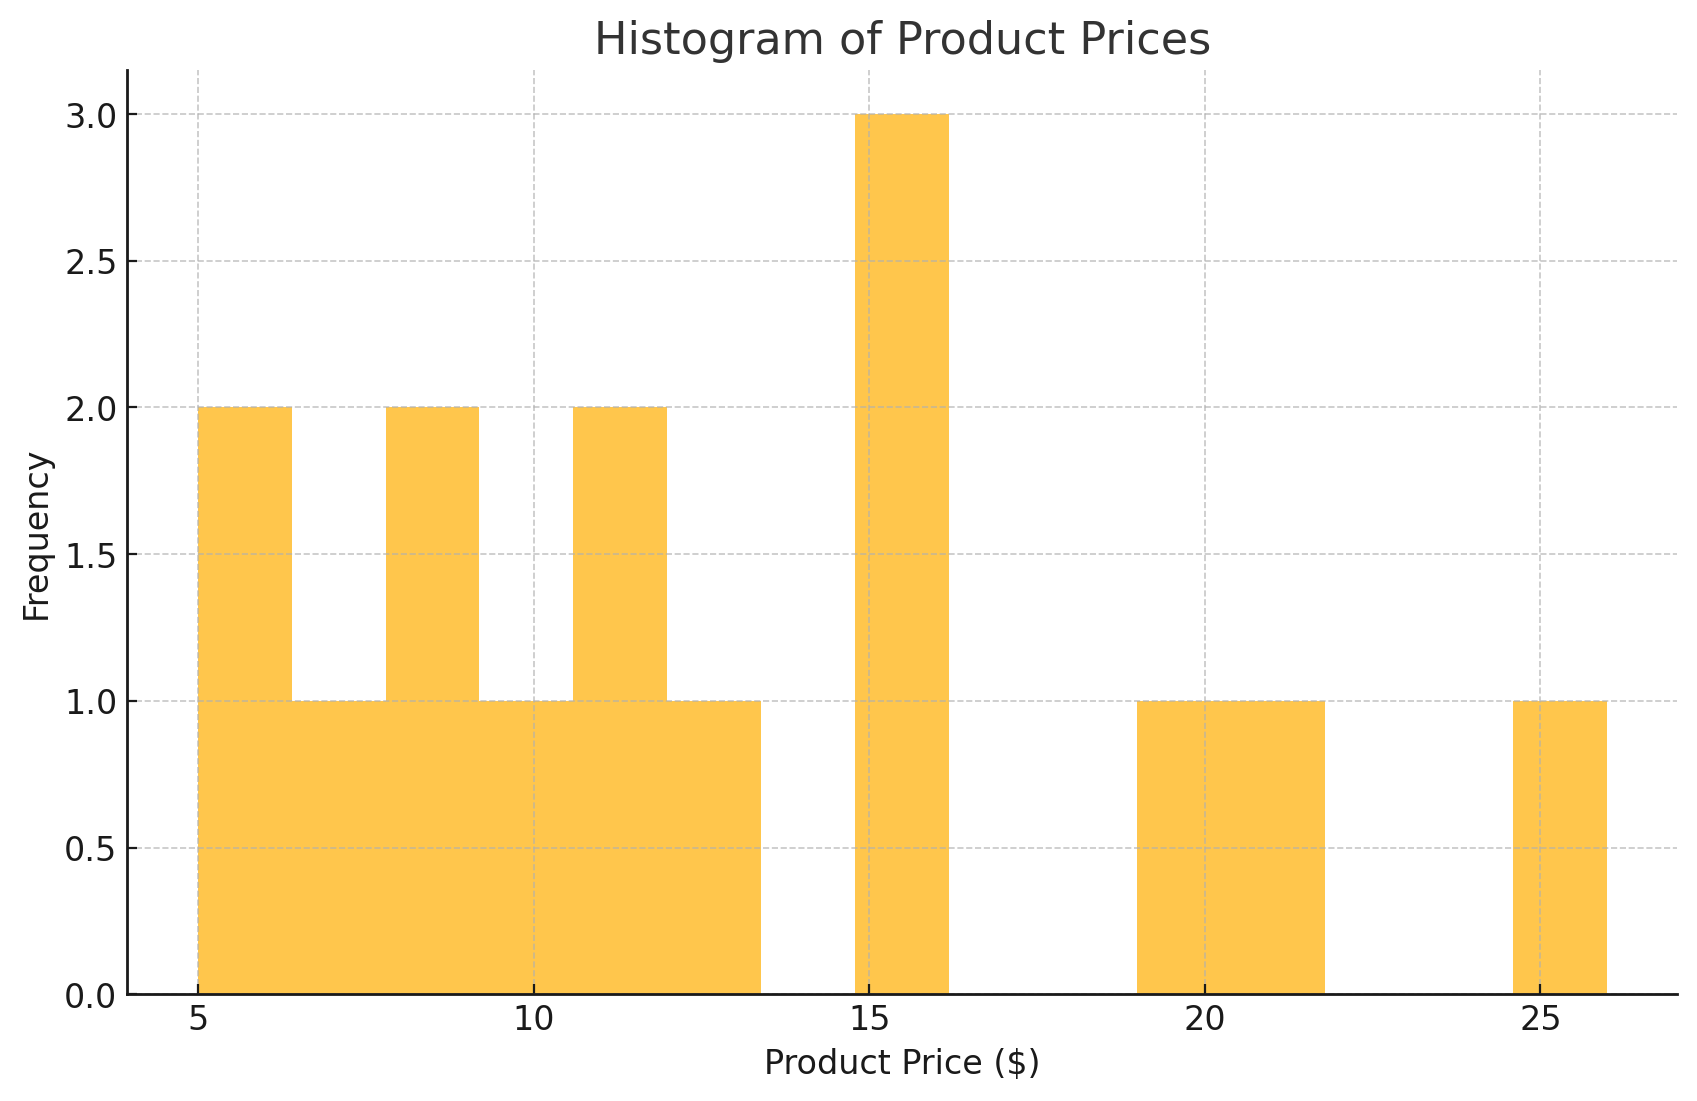

In [55]:
image_data = client.files.content(file_id).read()
image = Image.open(BytesIO(image_data))
image

Exercise: Create a line chart of the average number of sold items per month

status > queued
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > completed


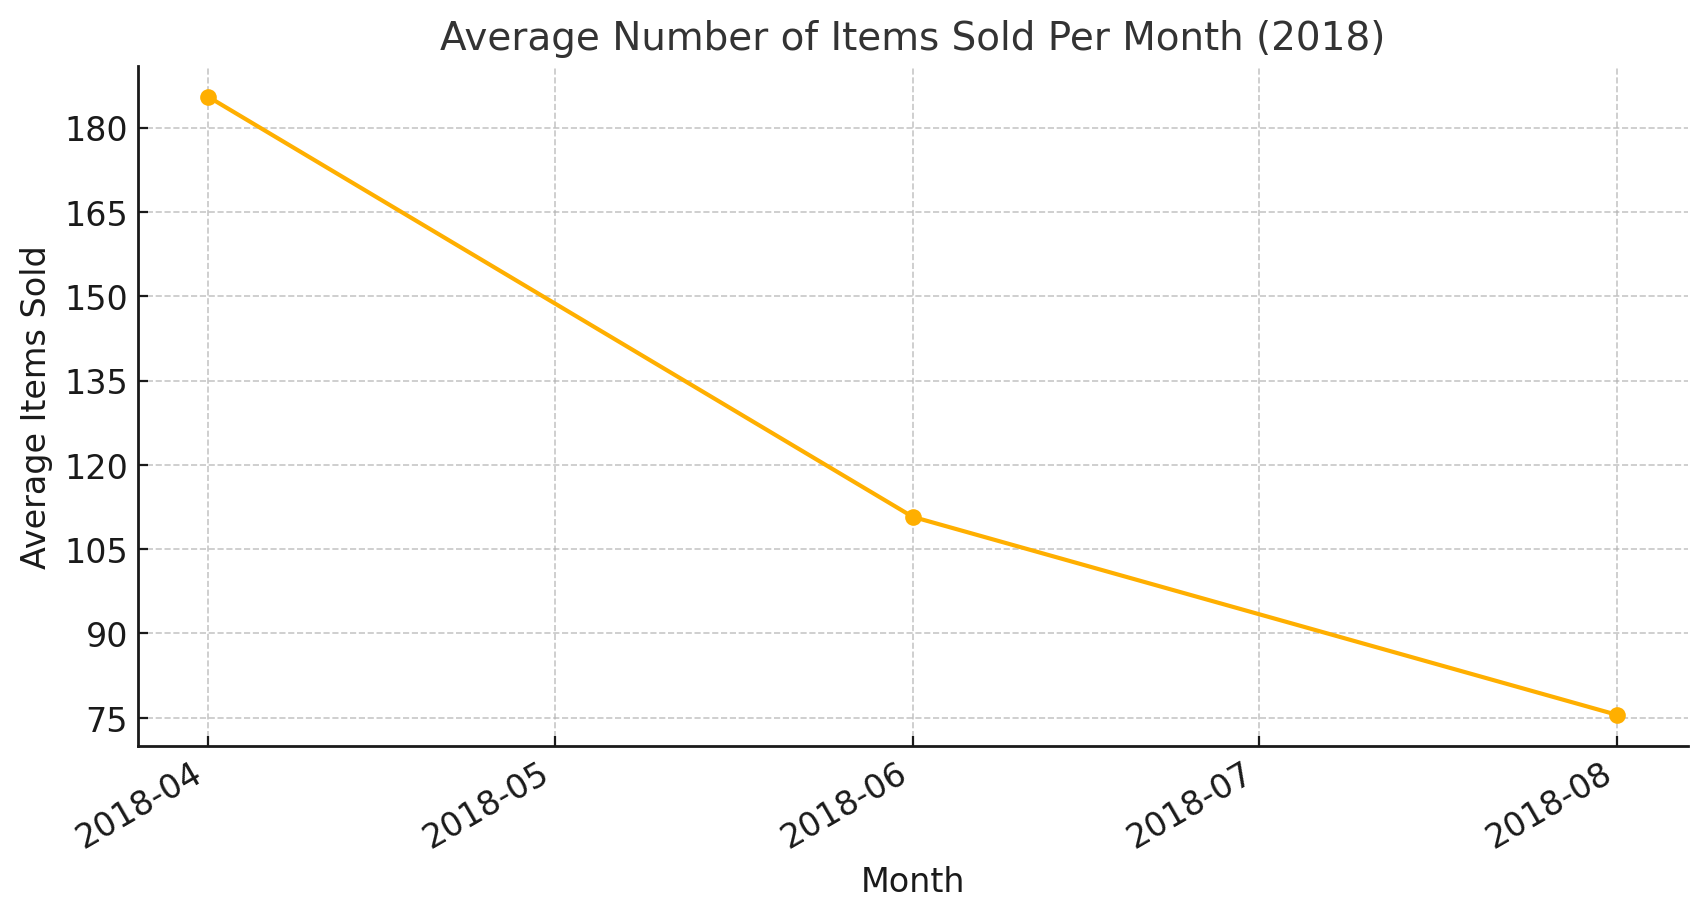

In [58]:
question = "create a line chart of the average number of sold items for each month. Have every month name on x axis"

mesages= send_message(assistant,thread.id,question)


answer = mesages[0]

file_id = answer.content[0].image_file.file_id
image_data = client.files.content(file_id).read()
image = Image.open(BytesIO(image_data))
image
